# Import packages

In [192]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset

# Configurations

In [194]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
config = {
    "batch_size": 16,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0, # Learning rate
    "gamma": 0.7, # Learning rate step gamma
    "dry_run": False,
    "seed": 1,
    "log_interval": 50,
    "data_dir": "./data"
}

# Import and Preprocessing Dataset

In [195]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = MNIST(root = './data', train = True, download = True, transform = transform)
test_set = MNIST(root = './data', train = False, download = False, transform = transform)

# Nerual Network Definition

In [196]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) # 1*28*28 -> 32*26*26
        x = F.relu(x)
        x = self.conv2(x) # 64*24*24
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 64*12*12
        x = self.dropout1(x) # 64*12*12
        x = torch.flatten(x, 1) # 9216
        x = self.fc1(x) # 128
        x = F.relu(x)
        x = self.dropout2(x) # 128
        x = self.fc2(x) # 10
        output = F.log_softmax(x, dim=1)
        return output

In [197]:
class OptimizeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_layers = nn.Sequential(
            nn.Conv2d(1, 64, 5, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 5, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.conv2_layers = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1_layers(x)
        x = self.conv2_layers(x)
        return self.fc_layers(x)

In [212]:
from torchsummary import summary
original_model = Net().to('cpu')
summary(original_model, (1, 28, 28))
optimize_model = OptimizeNet().to('cpu')
summary(optimize_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 6

In [199]:
from ptflops import get_model_complexity_info

net_flops, net_params = get_model_complexity_info(Net(), (1, 28, 28), as_strings=True, print_per_layer_stat=True)
print('FLOPs of Net: ' + net_flops)
print('Params of Net: ' + net_params)

optimize_net_flops, optimize_net_params = get_model_complexity_info(OptimizeNet(), (1, 28, 28), as_strings=True, print_per_layer_stat=True)
print('FLOPs of OptimizeNet: ' + optimize_net_flops)
print('Params of OptimizeNet: ' + optimize_net_params)

Net(
  1.2 M, 100.000% Params, 12.05 MMac, 99.214% MACs, 
  (conv1): Conv2d(320, 0.027% Params, 216.32 KMac, 1.781% MACs, 1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(18.5 k, 1.541% Params, 10.65 MMac, 87.710% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.25, inplace=False)
  (dropout2): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.5, inplace=False)
  (fc1): Linear(1.18 M, 98.324% Params, 1.18 MMac, 9.713% MACs, in_features=9216, out_features=128, bias=True)
  (fc2): Linear(1.29 k, 0.108% Params, 1.29 KMac, 0.011% MACs, in_features=128, out_features=10, bias=True)
)
FLOPs of Net: 12.15 MMac
Params of Net: 1.2 M
OptimizeNet(
  624.07 k, 100.000% Params, 52.54 MMac, 99.942% MACs, 
  (conv1_layers): Sequential(
    104.38 k, 16.726% Params, 42.16 MMac, 80.195% MACs, 
    (0): Conv2d(1.66 k, 0.267% Params, 958.46 KMac, 1.823% MACs, 1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(0, 0.000

# Training and Testing

In [200]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args['dry_run']:
                break

In [201]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy

# KPI1: Use 500 training samples.

## Randomly select 500 samples

In [202]:
def get_balanced_subset_indices(targets, num_per_class):
    indices = []
    for cnt in range(10):
        class_indices = (targets == cnt).nonzero(as_tuple=True)[0]
        random_indices = np.random.choice(class_indices, num_per_class, replace=False)
        indices.extend(random_indices)
    return indices

In [203]:
num_per_class = 50

train_indices = get_balanced_subset_indices(train_set.targets, num_per_class)

train_subset_500 = Subset(train_set, train_indices)

In [204]:
train_kwargs = {'batch_size': config['batch_size']}
test_kwargs = {'batch_size': config['test_batch_size']}
if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_set, **train_kwargs)
subset_train_loader = DataLoader(train_subset_500, **train_kwargs)
test_loader = DataLoader(test_set, **test_kwargs)

In [205]:
def train_and_test_model(net, train_loader):
    model = net.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=config['lr'])

    scheduler = StepLR(optimizer, step_size=1, gamma=config['gamma'])
    test_losses = []
    test_accuracies = []
    for epoch in range(1, config['epochs'] + 1):
        train(config, model, device, train_loader, optimizer, epoch)
        epoch_test_loss, epoch_test_accuracy = test(model, device, test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)
        scheduler.step()
    
    return test_losses, test_accuracies

In [206]:
original_test_losses, original_test_accuracies = train_and_test_model(Net(), subset_train_loader)

Train Epoch: 1 [0/500 (0%)]	Loss: 2.293764

Test set: Average loss: 6.9273, Accuracy: 1009/10000 (10%)

Train Epoch: 2 [0/500 (0%)]	Loss: 10.271166

Test set: Average loss: 6.7825, Accuracy: 1009/10000 (10%)

Train Epoch: 3 [0/500 (0%)]	Loss: 5.062599

Test set: Average loss: 5.3065, Accuracy: 1009/10000 (10%)

Train Epoch: 4 [0/500 (0%)]	Loss: 3.067391

Test set: Average loss: 4.9153, Accuracy: 1303/10000 (13%)

Train Epoch: 5 [0/500 (0%)]	Loss: 1.048810

Test set: Average loss: 4.3920, Accuracy: 3186/10000 (32%)

Train Epoch: 6 [0/500 (0%)]	Loss: 0.668641

Test set: Average loss: 3.6685, Accuracy: 3694/10000 (37%)

Train Epoch: 7 [0/500 (0%)]	Loss: 0.599413

Test set: Average loss: 3.2047, Accuracy: 4335/10000 (43%)

Train Epoch: 8 [0/500 (0%)]	Loss: 0.379923

Test set: Average loss: 2.9740, Accuracy: 4869/10000 (49%)

Train Epoch: 9 [0/500 (0%)]	Loss: 0.448369

Test set: Average loss: 2.8260, Accuracy: 5188/10000 (52%)

Train Epoch: 10 [0/500 (0%)]	Loss: 0.029731

Test set: Average 

### Data Augmentation

In [207]:
from torch.utils.data import ConcatDataset

augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

concat_dataset = train_subset_500
train_subset_500.dataset.transform = augment_transform

for i in range(5):
    concat_dataset = ConcatDataset([concat_dataset, train_subset_500])

augmented_train_loader = DataLoader(concat_dataset, **train_kwargs)

dataAugmentation_test_losses, dataAugmentation_test_accuracies = train_and_test_model(Net(), augmented_train_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.314889
Train Epoch: 1 [800/3000 (27%)]	Loss: 5.553911
Train Epoch: 1 [1600/3000 (53%)]	Loss: 6.333978
Train Epoch: 1 [2400/3000 (80%)]	Loss: 2.687444

Test set: Average loss: 3.4851, Accuracy: 3596/10000 (36%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.634615
Train Epoch: 2 [800/3000 (27%)]	Loss: 1.021991
Train Epoch: 2 [1600/3000 (53%)]	Loss: 1.452721
Train Epoch: 2 [2400/3000 (80%)]	Loss: 1.307162

Test set: Average loss: 1.9696, Accuracy: 5286/10000 (53%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.439983
Train Epoch: 3 [800/3000 (27%)]	Loss: 0.695100
Train Epoch: 3 [1600/3000 (53%)]	Loss: 0.583906
Train Epoch: 3 [2400/3000 (80%)]	Loss: 1.203319

Test set: Average loss: 1.4933, Accuracy: 6493/10000 (65%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.432202
Train Epoch: 4 [800/3000 (27%)]	Loss: 0.180900
Train Epoch: 4 [1600/3000 (53%)]	Loss: 0.074472
Train Epoch: 4 [2400/3000 (80%)]	Loss: 1.014860

Test set: Average loss: 1.0759, Accuracy: 7493/10000 (75%)

Train Ep

## Use the optimize model

In [208]:
optiNet_test_losses, optiNet_test_accuracies = train_and_test_model(OptimizeNet(), subset_train_loader)

Train Epoch: 1 [0/500 (0%)]	Loss: 3.012371

Test set: Average loss: 4.4499, Accuracy: 1057/10000 (11%)

Train Epoch: 2 [0/500 (0%)]	Loss: 3.113080

Test set: Average loss: 3.6644, Accuracy: 1683/10000 (17%)

Train Epoch: 3 [0/500 (0%)]	Loss: 0.935389

Test set: Average loss: 2.6243, Accuracy: 2841/10000 (28%)

Train Epoch: 4 [0/500 (0%)]	Loss: 2.102751

Test set: Average loss: 2.4473, Accuracy: 3189/10000 (32%)

Train Epoch: 5 [0/500 (0%)]	Loss: 0.770077

Test set: Average loss: 2.6728, Accuracy: 3333/10000 (33%)

Train Epoch: 6 [0/500 (0%)]	Loss: 1.055462

Test set: Average loss: 2.1958, Accuracy: 4518/10000 (45%)

Train Epoch: 7 [0/500 (0%)]	Loss: 0.631238

Test set: Average loss: 2.6625, Accuracy: 3879/10000 (39%)

Train Epoch: 8 [0/500 (0%)]	Loss: 1.056654

Test set: Average loss: 1.6994, Accuracy: 5847/10000 (58%)

Train Epoch: 9 [0/500 (0%)]	Loss: 0.188877

Test set: Average loss: 1.4286, Accuracy: 5801/10000 (58%)

Train Epoch: 10 [0/500 (0%)]	Loss: 1.005025

Test set: Average l

In [209]:
optiNet_dataAugmentation_test_losses, optiNet_dataAugmentation_test_accuracies = train_and_test_model(OptimizeNet(), augmented_train_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.269917
Train Epoch: 1 [800/3000 (27%)]	Loss: 3.597602
Train Epoch: 1 [1600/3000 (53%)]	Loss: 3.086811
Train Epoch: 1 [2400/3000 (80%)]	Loss: 1.960411

Test set: Average loss: 1.7854, Accuracy: 4615/10000 (46%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.804175
Train Epoch: 2 [800/3000 (27%)]	Loss: 2.232322
Train Epoch: 2 [1600/3000 (53%)]	Loss: 1.444391
Train Epoch: 2 [2400/3000 (80%)]	Loss: 1.015847

Test set: Average loss: 0.5770, Accuracy: 7961/10000 (80%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.309984
Train Epoch: 3 [800/3000 (27%)]	Loss: 0.180779
Train Epoch: 3 [1600/3000 (53%)]	Loss: 0.213858
Train Epoch: 3 [2400/3000 (80%)]	Loss: 0.821698

Test set: Average loss: 0.7641, Accuracy: 8017/10000 (80%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.024672
Train Epoch: 4 [800/3000 (27%)]	Loss: 0.009576
Train Epoch: 4 [1600/3000 (53%)]	Loss: 0.292596
Train Epoch: 4 [2400/3000 (80%)]	Loss: 0.064793

Test set: Average loss: 0.6706, Accuracy: 8251/10000 (83%)

Train Ep

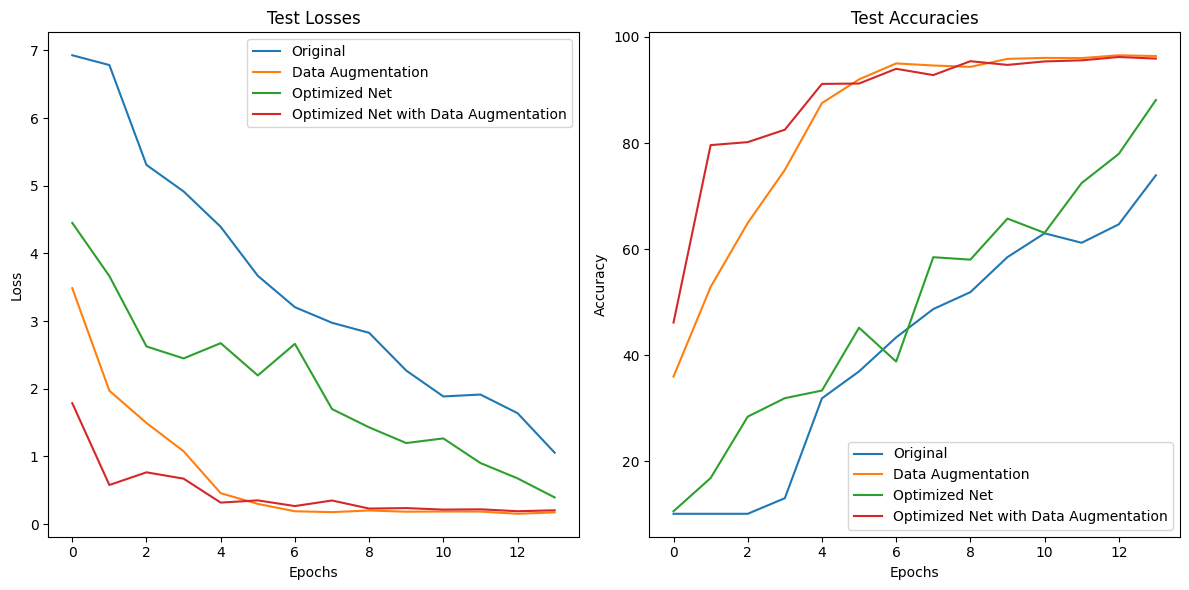

In [210]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(original_test_losses, label='Original')
plt.plot(dataAugmentation_test_losses, label='Data Augmentation')
plt.plot(optiNet_test_losses, label='Optimized Net')
plt.plot(optiNet_dataAugmentation_test_losses, label='Optimized Net with Data Augmentation')
plt.title('Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(original_test_accuracies, label='Original')
plt.plot(dataAugmentation_test_accuracies, label='Data Augmentation')
plt.plot(optiNet_test_accuracies, label='Optimized Net')
plt.plot(optiNet_dataAugmentation_test_accuracies, label='Optimized Net with Data Augmentation')
plt.title('Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# KPI2: Minimum samples for 95% accuracy

In [211]:
def find_minimum_samples_for_accuracy(net, train_set, target_accuracy=95):
    for num_per_class in range(25, 80 + 1, 2):
        train_indices = get_balanced_subset_indices(train_set.targets, num_per_class)
        train_subset = Subset(train_set, train_indices)
        train_loader = DataLoader(train_subset, **train_kwargs)

        _, test_accuracies = train_and_test_model(net, train_loader)

        if test_accuracies[-1] >= target_accuracy:
            return num_per_class * 10

minimum_samples_original = find_minimum_samples_for_accuracy(Net(), train_set)
minimum_samples_optimized = find_minimum_samples_for_accuracy(OptimizeNet(), train_set)
print(f'Minimum samples for 95% accuracy (original net): {minimum_samples_original}\n'
      f'Minimum samples for 95% accuracy (optimized net): {minimum_samples_optimized}')

Train Epoch: 1 [0/250 (0%)]	Loss: 2.304383

Test set: Average loss: 2.2994, Accuracy: 982/10000 (10%)

Train Epoch: 2 [0/250 (0%)]	Loss: 2.363671

Test set: Average loss: 2.2814, Accuracy: 3212/10000 (32%)

Train Epoch: 3 [0/250 (0%)]	Loss: 2.361044

Test set: Average loss: 2.2129, Accuracy: 1027/10000 (10%)

Train Epoch: 4 [0/250 (0%)]	Loss: 2.119463

Test set: Average loss: 2.1301, Accuracy: 2480/10000 (25%)

Train Epoch: 5 [0/250 (0%)]	Loss: 1.670588

Test set: Average loss: 2.7773, Accuracy: 2697/10000 (27%)

Train Epoch: 6 [0/250 (0%)]	Loss: 1.344252

Test set: Average loss: 2.3555, Accuracy: 3688/10000 (37%)

Train Epoch: 7 [0/250 (0%)]	Loss: 0.707231

Test set: Average loss: 2.6118, Accuracy: 3211/10000 (32%)

Train Epoch: 8 [0/250 (0%)]	Loss: 0.908490

Test set: Average loss: 2.0081, Accuracy: 4004/10000 (40%)

Train Epoch: 9 [0/250 (0%)]	Loss: 0.746507

Test set: Average loss: 1.5249, Accuracy: 4713/10000 (47%)

Train Epoch: 10 [0/250 (0%)]	Loss: 0.725020

Test set: Average lo